# Graphs in PySpark


Let's dive into Spark's tool for large‑scale graph processing – ***the GraphFrames library***.  

Apache Spark provides two main APIs for graph processing: **GraphX** (link to the full documentation can be found [here](http://spark.apache.org/docs/latest/graphx-programming-guide.html)) and **GraphFrames** (link to the full documentation can be found [here](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)). The first one (GraphX) is built on RDDs and available in Scala and Java, while the second one (GraphFrames) is built on DataFrames and is available in Python too (through the PySpark library).

In this notebook, we'll provide an overview of the **GraphFrames library**, demonstrating:
- The basic building blocks (vertices and edges).
- How to construct and query graphs using GraphFrames.
- Key functionalities like motif finding, subgraph operations, and more.
- How to perform famous algorithms, like BFS and PageRank, on graphs using GraphFrames.


## Graphs - Revisiting

A **graph** is a structure consisting of **nodes** (also called **vertices**) and **edges**. Formally:

$$
G = (V, E)
$$

- $V$ is the set of **vertices** (the “points” or “nodes”).
- $E$ is the set of **edges** (the “connections” between vertices).

### Directed vs. Undirected
- **Directed Graph**: Each edge has a direction. In mathematical terms:
  $$
  E \subseteq V \times V
  $$
  This means an edge is an ordered pair $(u, v)$ from vertex $u$ to vertex $v$.

- **Undirected Graph**: Edges go both ways. An edge here is an unordered pair $\{u, v\}$.

### Weighted Graphs
Some graphs attach a **weight** (numerical value) to each edge, for instance to represent cost or distance:
$$
w: E \to \mathbb{R}
$$

Overall, the essence of any graph is the set of nodes plus the set of links (edges) that connect them, whether those links are one-directional, two-directional, or assigned specific weights.

## Graphs in PySpark

Before we use GraphFrames, we need to have the right java package (JAR) installed.
Luckily, it is already installed for us 


In [1]:
!pip install graphframes # Install the python glue library to the java lib

Let's crate a SparkSession

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Graph Processing") \
    .master("local[*]")\
    .config("spark.jars","/home/jars/graphframes-0.8.4-spark3.5-s_2.12.jar") \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
!pip install kagglehub
import kagglehub
path = kagglehub.dataset_download("benhamner/sf-bay-area-bike-share")
print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/benhamner/sf-bay-area-bike-share/versions/2


Let's download the dataset containing information about bike trips in Bay Area in San Francisco

In [4]:
import os
import graphframes

filepath = os.path.join(path)
stations_df = spark.read.csv(f"{filepath}/station.csv", header=True)
trips_df = spark.read.csv(f"{filepath}/trip.csv", header=True)

### From regular DataFrames to a Graph

First, let's print the casual Spark DFs 

In [5]:
stations_df.show(truncate=False)

+---+---------------------------------+------------------+-------------------+----------+------------+-----------------+
|id |name                             |lat               |long               |dock_count|city        |installation_date|
+---+---------------------------------+------------------+-------------------+----------+------------+-----------------+
|2  |San Jose Diridon Caltrain Station|37.329732         |-121.90178200000001|27        |San Jose    |8/6/2013         |
|3  |San Jose Civic Center            |37.330698         |-121.888979        |15        |San Jose    |8/5/2013         |
|4  |Santa Clara at Almaden           |37.333988         |-121.894902        |11        |San Jose    |8/6/2013         |
|5  |Adobe on Almaden                 |37.331415         |-121.8932          |19        |San Jose    |8/5/2013         |
|6  |San Pedro Square                 |37.336721000000004|-121.894074        |15        |San Jose    |8/7/2013         |
|7  |Paseo de San Antonio       

In [6]:
trips_df.show(n=3, truncate=False, vertical=True)

-RECORD 0--------------------------------------
 id                 | 4576                     
 duration           | 63                       
 start_date         | 8/29/2013 14:13          
 start_station_name | South Van Ness at Market 
 start_station_id   | 66                       
 end_date           | 8/29/2013 14:14          
 end_station_name   | South Van Ness at Market 
 end_station_id     | 66                       
 bike_id            | 520                      
 subscription_type  | Subscriber               
 zip_code           | 94127                    
-RECORD 1--------------------------------------
 id                 | 4607                     
 duration           | 70                       
 start_date         | 8/29/2013 14:42          
 start_station_name | San Jose City Hall       
 start_station_id   | 10                       
 end_date           | 8/29/2013 14:43          
 end_station_name   | San Jose City Hall       
 end_station_id     | 10                

Now, let's build a Graph. The graphframes framework requires the nodes to have a unique identifier under the column `id` and the edges to have two columns identifying the nodes incident on the edge called `src` and `dst`. We will use the names of the stations as IDs because they are unqiue. A common convention is to have the date format as: `YYYY-MM-DD`, so we will convert the date format in our data to fit the common format.

In [7]:
from pyspark.sql.functions import *

station_vertices = stations_df.drop('id').withColumnRenamed('name', 'id').distinct()\
                                .withColumn('installation_datestamp', to_date('installation_date', 'M/d/yyyy'))\
                                .drop('installation_date')
trip_edges = trips_df.withColumnRenamed('start_station_name', 'src')\
                        .withColumnRenamed('end_station_name', 'dst').distinct()

# convert date to the 'YYYY-MM-DD' format.drop(col_name) for future use
date_columns = ['start_date', 'end_date']
for col_name in date_columns:
    trip_edges = trip_edges.withColumn(f'{col_name}stamp', to_timestamp(col_name, 'M/d/yyyy H:mm'))

In [8]:
from graphframes import GraphFrame

station_graph = GraphFrame(station_vertices, trip_edges)

trip_edges.cache()
station_vertices.cache()

DataFrame[id: string, lat: string, long: string, dock_count: string, city: string, installation_datestamp: date]

Before we proceed, let's visualize the graph by taking a sample of 500 edges. 

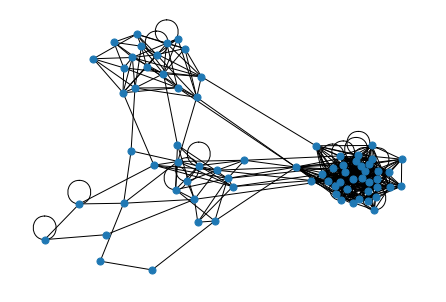

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

edges_viz = trip_edges.dropDuplicates(['src','dst'])

# plotting the graph
def plot_graph(edge_list):
    Gplot = nx.Graph()
    # drop duplicates to ensure a 'map'
    for row in edge_list.select('src', 'dst').take(500):
        Gplot.add_edge(row['src'], row['dst'])
    
    nx.draw(Gplot, node_size=50)
    plt.show()
    
plot_graph(edges_viz)

Essentially, what we see in the graph is a map of all the bike station links, where links are defined by a trip made by someone in the past.

**Note:** 
1. The edge list can change from run to run because Spark’s distributed scheduler sends whichever partitions finish first to the driver, so `take(500)` (which is identical to `limit(500).collect()`) samples a nondeterministic slice of the data. 
2. Even if the edges are identical, NetworkX’s default `spring_layout` starts from a random seed, so node coordinates differ each time the layout is recomputed.  

Make the plot repeatable by fully ordering the DataFrame on a unique key before you `collect()` **and** giving the layout a fixed seed (e.g., `pos = nx.spring_layout(Gplot, seed=42); nx.draw(Gplot, pos=pos, node_size=50)`).


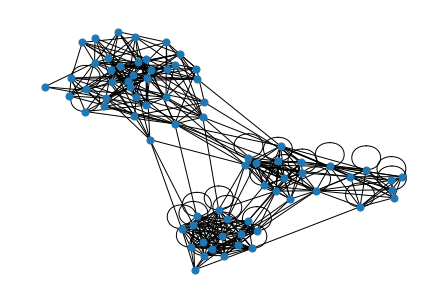

In [10]:
# plot so that visualization is the same from run to run
def plot_graph_deterministic(edge_list):
    Gplot = nx.Graph()
    # enforce an order on the 'bike_id' column before sampling 
    for row in edge_list.select('src', 'dst').orderBy('bike_id').limit(500).collect():
        # drop duplicates to ensure a 'map'
        Gplot.add_edge(row['src'], row['dst'])
    
    layout = nx.spring_layout(Gplot, seed=1)  # repeatable layout
    nx.draw(Gplot, pos=layout, node_size=50)
    plt.show()
    
plot_graph_deterministic(edges_viz)

In [11]:
trip_edges.unpersist()
station_vertices.unpersist()

DataFrame[id: string, lat: string, long: string, dock_count: string, city: string, installation_datestamp: date]

### Trip Popularity (Basic DF Operations)

Let's start off by mentioning that both the edges and the vertices in the GraphFrame are treated as a DataFrame. We can perform all the basic operations like `groupby()`, `sort()`, `select()` and so on on the set of nodes and the set of the edges.

One question we might ask is 'How popular is a certain link between stations?'. Another is: 'What are the stations that contain the most docks for bikes (parking spots)?'

In [12]:
top_trips = (
    station_graph
    .edges
    .groupBy("src", "dst")
    .count()
    .orderBy(desc("count"))
    .limit(10))

top_trips.show(truncate=False)

+----------------------------------------+----------------------------------------+-----+
|src                                     |dst                                     |count|
+----------------------------------------+----------------------------------------+-----+
|San Francisco Caltrain 2 (330 Townsend) |Townsend at 7th                         |6216 |
|Harry Bridges Plaza (Ferry Building)    |Embarcadero at Sansome                  |6164 |
|Townsend at 7th                         |San Francisco Caltrain (Townsend at 4th)|5041 |
|2nd at Townsend                         |Harry Bridges Plaza (Ferry Building)    |4839 |
|Harry Bridges Plaza (Ferry Building)    |2nd at Townsend                         |4357 |
|Embarcadero at Sansome                  |Steuart at Market                       |4269 |
|Embarcadero at Folsom                   |San Francisco Caltrain (Townsend at 4th)|3967 |
|Steuart at Market                       |2nd at Townsend                         |3903 |
|2nd at So

In [13]:
most_docks = (
        station_graph.vertices\
        .orderBy(desc('dock_count'))\
        .select(['id', 'dock_count'])
        .limit(10))

most_docks.show(truncate=False)

+---------------------------------------------+----------+
|id                                           |dock_count|
+---------------------------------------------+----------+
|San Jose Diridon Caltrain Station            |27        |
|Market at Sansome                            |27        |
|Market at 10th                               |27        |
|2nd at Townsend                              |27        |
|Redwood City Caltrain Station                |25        |
|Civic Center BART (7th at Market)            |23        |
|Steuart at Market                            |23        |
|Temporary Transbay Terminal (Howard at Beale)|23        |
|Palo Alto Caltrain Station                   |23        |
|San Antonio Caltrain Station                 |23        |
+---------------------------------------------+----------+



### Degree Analysis

Another question we might ask is related to degrees of the nodes in our graph. Before continuing with a question, here is a quick revision on the definitions of a degree in a graph.

In a **directed graph**, each node $v$ has two degree measures:
- **In-degree** $deg_{in}(v)$: The number of incoming edges to $v$.
- **Out-degree** $deg_{out}(v)$: The number of outgoing edges from $v$.

Formally,
$$
deg_{in}(v) = \sum_{u \in V} \mathbf{1}((u \to v) \in E), \quad
deg_{out}(v) = \sum_{w \in V} \mathbf{1}((v \to w) \in E)
$$
where $\mathbf{1}$ is an indicator function that is $1$ if the edge exists, and $0$ otherwise.

For an **undirected graph**, each node $v$ has just one degree measure:
$$
deg(v) = \sum_{x \in V} \mathbf{1}((v, x) \in E)
$$
which counts all edges incident to $v$, without distinguishing between “in” or “out” directions.


Now, let's ask what are the stations with the most in-bound traffic and out-bound traffic. This gives key insights on which stations are more popular than the other.

In [14]:
# station with the biggest in-bound traffic
in_deg = station_graph.inDegrees
in_deg.orderBy(desc("inDegree")).limit(5).show(truncate=False)

+----------------------------------------+--------+
|id                                      |inDegree|
+----------------------------------------+--------+
|San Francisco Caltrain (Townsend at 4th)|63179   |
|San Francisco Caltrain 2 (330 Townsend) |35117   |
|Harry Bridges Plaza (Ferry Building)    |33193   |
|Embarcadero at Sansome                  |30796   |
|2nd at Townsend                         |28529   |
+----------------------------------------+--------+



In [15]:
# stations with the most out-bound traffic
out_deg = station_graph.outDegrees
out_deg.orderBy(desc("outDegree")).limit(5).show(truncate=False)

+---------------------------------------------+---------+
|id                                           |outDegree|
+---------------------------------------------+---------+
|San Francisco Caltrain (Townsend at 4th)     |49092    |
|San Francisco Caltrain 2 (330 Townsend)      |33742    |
|Harry Bridges Plaza (Ferry Building)         |32934    |
|Embarcadero at Sansome                       |27713    |
|Temporary Transbay Terminal (Howard at Beale)|26089    |
+---------------------------------------------+---------+



One more interesting question that arises when doing a degree analysis is how to identify “sink” and “source” stations by examining their in-degree/out-degree ratios, or in other words, determining which stations receive all trips (sink) or originate them (source) by comparing the balance of incoming and outgoing edges. We will do so by ranking the stations according to their 'in-degree/out-degree' ratio (low ratio - source station, high ratio - sink station). Values close to 1 mean that the station has similar in-bound and out-bound traffic.

In [16]:
degree_ratio = (
    in_deg.join(out_deg, "id")
    .selectExpr("id", "double(inDegree)/double(outDegree) as degreeRatio"))

In [17]:
degree_ratio.orderBy(desc("degreeRatio")).limit(10).show(truncate=False)

+----------------------------------------+------------------+
|id                                      |degreeRatio       |
+----------------------------------------+------------------+
|Redwood City Medical Center             |1.4533762057877813|
|Redwood City Public Library             |1.300469483568075 |
|San Francisco Caltrain (Townsend at 4th)|1.286951030717836 |
|Washington at Kearny                    |1.2723671947809878|
|MLK Library                             |1.233038348082596 |
|SJSU 4th at San Carlos                  |1.2282051282051283|
|San Mateo County Center                 |1.2195121951219512|
|Broadway at Main                        |1.208955223880597 |
|University and Emerson                  |1.2056878306878307|
|Washington at Kearney                   |1.203804347826087 |
+----------------------------------------+------------------+



In [18]:
degree_ratio.orderBy(asc("degreeRatio")).limit(10).show(truncate=False)

+-------------------------------+------------------+
|id                             |degreeRatio       |
+-------------------------------+------------------+
|Grant Avenue at Columbus Avenue|0.564700110388814 |
|2nd at Folsom                  |0.6056461731493099|
|Powell at Post (Union Square)  |0.6887003841229193|
|San Jose City Hall             |0.6928541579607188|
|San Francisco City Hall        |0.7497243660418964|
|Beale at Market                |0.774906104780699 |
|Redwood City Caltrain Station  |0.8075933075933076|
|Golden Gate at Polk            |0.8153091800599291|
|Evelyn Park and Ride           |0.8218356328734253|
|Ryland Park                    |0.8248425872925015|
+-------------------------------+------------------+



### Motifs

**Motifs** (full documentation can be found [here](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#motif-finding)) in GraphFrames allow you to search for structural patterns in your graph data. A motif is essentially a user-defined pattern of connected vertices and edges. By specifying a motif, you can uncover hidden relationships, discover common substructures (e.g., triangles, squares), and gain richer insights from your graph. This is especially useful for tasks like detecting social network patterns, identifying communication patterns in logs, or discovering frequent substructures in large datasets. the result of running `find()` is a Dataframe consisting of all the vertices Structs and edges Structs in the structure we are looking for. 

**Note:** We can omit the name of an edge or a vertex while looking for a motif. *Example*: `(a)-[]->(b)` - this will look for all the directed edges from 'a' to 'b', but in the resulting DataFrame, the struct for the edge 'e' is going to be omitted.

Let's look at an example of motifs.

In [ ]:
motifs = station_graph.find("(a)-[e]->(b); (b)-[e2]->(a)")       # find stations for which there was a trip between them in both directions
motifs = motifs.where(col('e.bike_id') == col('e2.bike_id'))     # filter so that the 'bike_id' is the same in 'e' and 'e2'
motifs = motifs.where(col('a.id') != col('b.id'))                # filter so that the stations are distinct

# filter so that the difference between the start of the 'return' trip and the end of the 'start' trip of the same bike is not more than 5 minutes long
motifs = motifs.withColumn('Minute_Diff', ((col('e2.start_datestamp').cast('long') - col('e.end_datestamp').cast('long')) / 60))
motifs = motifs.where((col('Minute_Diff') < 5) & (col('Minute_Diff') >= 0)) 
motifs_result = motifs.select(col('a.id').alias('Station A'), col('b.id').alias('Station B'), col('Minute_Diff'), 'e.end_datestamp', 'e2.start_datestamp')\
        .sort('Minute_Diff', ascending=True)
motifs_result.show(n=6, truncate=False, vertical=True)
print(f"Count of the filtered Motifs: {motifs_result.count()}")

-RECORD 0----------------------------------------
 Station A       | Beale at Market               
 Station B       | Market at 10th                
 Minute_Diff     | 0.0                           
 end_datestamp   | 2015-06-22 13:19:00           
 start_datestamp | 2015-06-22 13:19:00           
-RECORD 1----------------------------------------
 Station A       | Market at Sansome             
 Station B       | 2nd at South Park             
 Minute_Diff     | 0.0                           
 end_datestamp   | 2014-10-06 18:09:00           
 start_datestamp | 2014-10-06 18:09:00           
-RECORD 2----------------------------------------
 Station A       | San Mateo County Center       
 Station B       | Redwood City Caltrain Station 
 Minute_Diff     | 0.0                           
 end_datestamp   | 2015-04-06 12:32:00           
 start_datestamp | 2015-04-06 12:32:00           
-RECORD 3----------------------------------------
 Station A       | San Mateo County Center       


In the above example, we searched for bike rides where the same bike traveled from station A to station B and then quickly made a return trip from B to A. We filtered for a time difference of under 5 minutes between the end of the first ride and the start of the second ride, focusing on these short round-trips.

### SubGraphs

**Given a graph:** $G = (V, E)$

**Subgraph:** $G' = (V', E')$ is a subgraph of $G$ if $V' \subseteq V$ and $E' \subseteq E$, with every edge in $E'$ having endpoints in $V'$.

**Induced Subgraph:** For any subset of vertices $V' \subseteq V$, the induced subgraph $G[V']$ is $G' = (V', E')$, where  
$$ E' = \{(u,v) \in E \mid u \in V' \text{ and } v \in V' \}. $$

We can filter out filters and edges and yield a subgraph by the following methods: `filterVertices(condition)`, `filterEdges(condition)` and `dropIsolatedVertices()`. 

More usage examples of Subgraphs in GraphFrames can be found [here](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#subgraphs)

In [20]:
# only consider stations in San Jose and don't consider the stations with no outcoming and incoming trips 
subgraph = station_graph.filterVertices("city == 'San Jose'").dropIsolatedVertices()
subgraph.edges.select('src', 'dst', 'duration', 'start_datestamp', 'end_datestamp').sort(desc(col('duration'))).show(n=5, truncate=False)

+-------------------------------+------------------------+--------+-------------------+-------------------+
|src                            |dst                     |duration|start_datestamp    |end_datestamp      |
+-------------------------------+------------------------+--------+-------------------+-------------------+
|St James Park                  |San Pedro Square        |99993   |2014-02-05 11:50:00|2014-02-06 15:37:00|
|Adobe on Almaden               |San Salvador at 1st     |99951   |2015-06-12 22:39:00|2015-06-14 02:25:00|
|San Salvador at 1st            |Paseo de San Antonio    |999     |2014-07-26 16:39:00|2014-07-26 16:56:00|
|Santa Clara County Civic Center|Arena Green / SAP Center|999     |2015-01-20 16:08:00|2015-01-20 16:25:00|
|Santa Clara County Civic Center|MLK Library             |999     |2015-02-13 12:09:00|2015-02-13 12:26:00|
+-------------------------------+------------------------+--------+-------------------+-------------------+
only showing top 5 rows



GraphFrames provides even a more powerful approach to construct subgraphs using motifs. Let's see an example of this.

In [21]:
motifs = (
    station_graph
        .find("(a)-[e]->(b)")
        # trips from a city to a different city
        .filter(col('a.city') != col('b.city'))
        # trips more than 10 minutes
        .filter(col('e.duration') > 600)
)

new_edges = motifs.select('e.src', 'e.dst', 'e.duration')
subgraph = GraphFrame(station_graph.vertices, new_edges)
subgraph.edges.sort(desc(col('duration'))).show(n=5, truncate=False)

+-------------------------------+-------------------------------+--------+
|src                            |dst                            |duration|
+-------------------------------+-------------------------------+--------+
|San Antonio Caltrain Station   |California Ave Caltrain Station|999     |
|San Antonio Shopping Center    |Cowper at University           |9984    |
|California Ave Caltrain Station|San Antonio Caltrain Station   |996     |
|San Antonio Caltrain Station   |Park at Olive                  |993     |
|San Antonio Shopping Center    |California Ave Caltrain Station|993     |
+-------------------------------+-------------------------------+--------+
only showing top 5 rows



### Graph Algorithms

GraphFrames also provides us with a collection of graph algorithms' implementation — PageRank, BFS, connected components.
Full catalog of algorothms and more usage examples can be found [here](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#graph-algorithms).

#### BFS (Breadth-First-Search)

**Overview:**  
BFS is a fundamental graph traversal technique. Given a graph $G = (V, E)$ and a starting node $s$, BFS explores all vertices at the current depth before moving on to the next depth level. In an unweighted graph, this also gives the shortest path (in terms of edge count) from $s$ to every reachable vertex. 

**Time Complexity:**  
The complexity of the algorithm is $O(|V| + |E|)$.

For a concise overview of the BFS algorithm, see its [Wikipedia article](https://en.wikipedia.org/wiki/Breadth-first_search).


We will work with the **`top_trips`** GraphFrame from earlier, which aggregates trips by their source and destination stations. Instead of focusing on each individual trip, we’re now abstracting the data to look at how stations connect to one another (i.e., building a station “map”). By grouping and summarizing rides between stations in `top_trips`, we can more easily explore the structural relationships (graph perspective) of our network.


In [22]:
station_graph.vertices.select('city').distinct().show(truncate=False)

+-------------+
|city         |
+-------------+
|Palo Alto    |
|San Francisco|
|San Jose     |
|Redwood City |
|Mountain View|
+-------------+



In [23]:
map_stations = station_graph.edges\
    .groupBy("src", "dst")\
    .count()
print(map_stations.count())
map_stations.show(n=5, truncate=False)

map_graph = GraphFrame(station_graph.vertices, map_stations)

1916
+-------------------------------+----------------------------------------+-----+
|src                            |dst                                     |count|
+-------------------------------+----------------------------------------+-----+
|2nd at Folsom                  |San Francisco Caltrain (Townsend at 4th)|2121 |
|University and Emerson         |California Ave Caltrain Station         |175  |
|Market at 10th                 |Market at 10th                          |666  |
|Grant Avenue at Columbus Avenue|Mechanics Plaza (Market at Battery)     |422  |
|Golden Gate at Polk            |Steuart at Market                       |288  |
+-------------------------------+----------------------------------------+-----+
only showing top 5 rows



BFS takes two arguments: SQL filter on the source node and an SQL filter on the destination node. Let's try to find a shortest path between some station in San Jose and some station in Redwood City

In [24]:
paths_sanjose_redwood = map_graph.bfs("city == 'San Jose'", "city == 'Redwood City'", )
paths_sanjose_redwood.show(n=3, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------
 from | {Santa Clara County Civic Center, 37.352601, -121.90573300000001, 15, San Jose, 2013-12-31}  
 e0   | {Santa Clara County Civic Center, California Ave Caltrain Station, 1}                        
 v1   | {California Ave Caltrain Station, 37.429082, -122.14280500000001, 15, Palo Alto, 2013-08-14} 
 e1   | {California Ave Caltrain Station, Stanford in Redwood City, 6}                               
 to   | {Stanford in Redwood City, 37.48537, -122.20328799999999, 15, Redwood City, 2013-08-12}      
-RECORD 1--------------------------------------------------------------------------------------------
 from | {Japantown, 37.348742, -121.89471499999999, 15, San Jose, 2013-08-05}                        
 e0   | {Japantown, Cowper at University, 2}                                                         
 v1   | {Cowper at University, 37.448598, -122.159504, 11, Palo Alto, 2013-08-14} 

Let'do the same, but with San Jose and San Francisco

In [25]:
paths_sanjose_sanfrancisco = map_graph.bfs("city == 'San Jose'", "city == 'San Francisco'", )
paths_sanjose_sanfrancisco.show(n=3, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------
 from | {Santa Clara at Almaden, 37.333988, -121.894902, 11, San Jose, 2013-08-06}                                
 e0   | {Santa Clara at Almaden, San Francisco Caltrain (Townsend at 4th), 1}                                     
 to   | {San Francisco Caltrain (Townsend at 4th), 37.776617, -122.39526000000001, 19, San Francisco, 2013-08-23} 
-RECORD 1---------------------------------------------------------------------------------------------------------
 from | {San Jose Civic Center, 37.330698, -121.888979, 15, San Jose, 2013-08-05}                                 
 e0   | {San Jose Civic Center, Civic Center BART (7th at Market), 1}                                             
 to   | {Civic Center BART (7th at Market), 37.781039, -122.411748, 23, San Francisco, 2013-08-23}                
-RECORD 2-----------------------------------------------------------------------

We observe that traveling from San Jose to Redwood in our graph requires two hops—specifically, San Jose → Palo Alto → Redwood. In other words, there is no single trip (direct edge) in the dataset from San Jose to Redwood. By contrast, San Jose to San Francisco is just one hop because we actually see a direct trip recorded between these two cities. This highlights that our data shows a more “direct bridge” from San Jose to San Francisco, whereas reaching Redwood from San Jose requires going through Palo Alto first.

#### Connected Components (CC)

A **connected component** of an undirected graph $G = (V, E)$ is a maximal set of vertices such that **every vertex** in the set is reachable from **every other** vertex in the set. In other words, if you pick any two vertices $u$ and $v$ within the same connected component, there must be a path from $u$ to $v$ and (trivially) from $v$ back to $u$.

For a concise overview of the Connected Components, see its [Wikipedia article](https://en.wikipedia.org/wiki/Connected_component_(graph_theory)).

In the context of bike-sharing data, finding connected components can help us understand groups of stations that form **tight loops** of travel where each station is reachable from every other station in that group. This can be particularly revealing about stations often visited mutually within a short timeframe.

In the code snippet, we:

1. **Filtered and grouped** our edges by **short trip duration** ($\le 600$ seconds) to focus on quickly traversed, closely related stations.
2. Created a **new GraphFrame** using these short-trip edges, effectively focusing on a subgraph that emphasizes more “local” movements.
4. **Ran the Connected Components algorithm** to see which stations fall into tightly knit clusters **under these short-travel constraints**.

This approach helps isolate **subnetworks** of stations that might share geographical proximity.


In [26]:
short_edges = station_graph.edges.filter(col('duration') <= 600)\
                                    .groupBy(['src','dst'])\
                                    .agg(avg('duration'))
component_graph = GraphFrame(station_graph.vertices, short_edges)

In [27]:
sc.setCheckpointDir("/tmp/spark-checkpoints")

components = component_graph.connectedComponents()
components.select('city','component').distinct().show()

+-------------+------------+
|         city|   component|
+-------------+------------+
| Redwood City|           0|
|     San Jose|128849018880|
|San Francisco|           0|
|Mountain View|257698037760|
|    Palo Alto|  8589934592|
+-------------+------------+



In [28]:
redwood_ids = station_graph.vertices.where(col('city') == 'Redwood City').select('id').distinct().collect()
redwood_ids = [row['id'] for row in redwood_ids]
francisco_ids = station_graph.vertices.where(col('city') == 'San Francisco').select('id').distinct().collect()
francisco_ids = [row['id'] for row in francisco_ids]
                                            
edges_filtered = short_edges.where(col('src').isin(redwood_ids))\
                            .where(col('dst').isin(francisco_ids))
edges_filtered.show(truncate=False)

+-----------------------------+---------------------------------+-------------+
|src                          |dst                              |avg(duration)|
+-----------------------------+---------------------------------+-------------+
|Redwood City Caltrain Station|Civic Center BART (7th at Market)|236.0        |
+-----------------------------+---------------------------------+-------------+



Actually, an interesting observation from the **SCC (Strongly Connected Components)** analysis is that some stations end up grouped together in suspiciously short loops. This strongly suggests data anomalies—e.g., unrealistically short ride durations or incorrect timestamps. We may need to filter or clean these entries before drawing final conclusions.

An example above shows that San Francisco and Redwood City end up in the same component, with an average short (under 10 minutes) bike ride between them showing a duration of **236 seconds**. This is likely **not physically feasible** given the real distance between these two cities, which implies that certain data points (e.g., timestamps, station IDs, or intermediate trips) may have been logged improperly. As a result, further data cleaning steps—such as discarding unreasonably short or suspicious trips—would be necessary to ensure the analysis accurately reflects real-world behavior.

#### PageRank

PageRank is a classic algorithm that measures the relative importance of each vertex in a directed graph. Originally developed for web pages, the idea is that a node is considered *important* if it is linked to by other important nodes. In each iteration, PageRank redistributes a fraction of a node’s score among its outgoing edges and applies a “random jump” factor to handle sinks and ensure convergence.

PageRank score for each vertex can be found by solving the following set of lin. equations:

$$
\text{PR}(v) = \frac{1 - d}{N} \;+\; d \sum_{u \in \mathrm{In}(v)} \frac{\text{PR}(u)}{\text{outdegree}(u)}
$$

where
- $v$ is a vertex in the graph,
- $d$ is the damping factor,
- $N$ is the total number of vertices,
- $\mathrm{In}(v)$ is the set of vertices linking *into* $v$,
- $deg_{out}(u)$ is the number of outgoing edges from node $u$.

For a concise overview of the PageRank algorithm, see its [Wikipedia article](https://en.wikipedia.org/wiki/Connected_component_(graph_theory)).

In [29]:
# resetProbability - damping factor,   tol - convergence tolerance
pagerank_scores = map_graph.pageRank(resetProbability=0.15, tol=0.05).vertices\
                           .select('id', 'pagerank')\
                           .sort(desc(col('pagerank')))
pagerank_scores.show(n=5, truncate=False)

+----------------------------------------+------------------+
|id                                      |pagerank          |
+----------------------------------------+------------------+
|San Francisco Caltrain (Townsend at 4th)|1.4453393585537728|
|Civic Center BART (7th at Market)       |1.2164931710492708|
|Market at 4th                           |1.2164871434037323|
|Beale at Market                         |1.1386423430288939|
|Market at Sansome                       |1.1386423430288939|
+----------------------------------------+------------------+
only showing top 5 rows



These top-ranked stations in San Francisco appear frequently in the trip data as highly “connected” hubs. They either have a lot of incoming edges (popular drop-off points) or a large overall flow of trips, which boosts their PageRank score. It makes sense that high-traffic transit areas like Caltrain stations or central BART stops rank above less frequented stations, reflecting their importance in the network.

#### Aggregate Messages

`AggregateMessages` in GraphFrames (more usage examples can be found [here](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#message-passing-via-aggregatemessages)) lets you send and receive messages among vertices based on edge relationships, then aggregate those messages in a single pass—similar to the synchronized model in distributed computing. Each vertex can receive data from its neighbors (defined by `sendToSrc` or `sendToDst`), and GraphFrames applies an aggregation function (e.g., sum, count) to all incoming messages. By chaining multiple rounds of message passing and aggregation, you can replicate many iterative graph algorithms (e.g., PageRank, connected components) in a **distributed** DataFrame-based environment.

Read more about Distributed Computing [here](https://en.wikipedia.org/wiki/Distributed_computing)


In [30]:
from graphframes.lib import AggregateMessages as AM

msgToDst = AM.edge["duration"]

inbound_durations = station_graph.aggregateMessages(
    sum(AM.msg).alias("sumInboundDuration"),
    sendToDst=msgToDst  # send the duration to the 'dst' vertex
)
inbound_durations.sort(desc('sumInboundDuration')).show(truncate=False)

+---------------------------------------------+------------------+
|id                                           |sumInboundDuration|
+---------------------------------------------+------------------+
|Embarcadero at Sansome                       |5.1942975E7       |
|San Francisco Caltrain (Townsend at 4th)     |4.7498255E7       |
|Harry Bridges Plaza (Ferry Building)         |3.8347714E7       |
|Powell Street BART                           |2.5832529E7       |
|Market at 4th                                |2.5404823E7       |
|2nd at Folsom                                |2.4514554E7       |
|Market at Sansome                            |2.3674054E7       |
|San Francisco Caltrain 2 (330 Townsend)      |2.3592293E7       |
|Market at 10th                               |2.2606488E7       |
|Steuart at Market                            |2.1855888E7       |
|2nd at Townsend                              |2.152624E7        |
|Powell at Post (Union Square)                |1.9559066E7    

We use `AggregateMessages` to calculate, for each station, the **sum of the durations** of all inbound trips. Specifically, each edge sends its `duration` to the destination station, and then we aggregate (using `sum`) those values. Sorting the result in descending order reveals which stations receive the **greatest total ride time**—valuable for spotting major endpoints or hubs where users tend to conclude longer rides.

### Saving and Loading GraphFrames

Since the GraphFrames library is built on top of DataFrames, the saving and loading of the graphs is strightforward. We need to save the `edges` DataFrame and the `nodes` DataFrame into Parquet (or any other format that suits you) and then load these DataFrames and construct the GraphFrame.

In [33]:
# writing components of the graph
station_graph.vertices.write.parquet('../graph_save/nodes', mode='overwrite')
station_graph.edges.write.parquet('../graph_save/edges', mode='overwrite')

In [34]:
# loading components of the graph
nodes = spark.read.parquet('../graph_save/nodes')
edges = spark.read.parquet('../graph_save/edges')
loaded_graph = GraphFrame(nodes, edges)

loaded_graph.vertices.show(truncate=False)

+------------------------------------+------------------+-------------------+----------+-------------+----------------------+
|id                                  |lat               |long               |dock_count|city         |installation_datestamp|
+------------------------------------+------------------+-------------------+----------+-------------+----------------------+
|Arena Green / SAP Center            |37.332692         |-121.900084        |19        |San Jose     |2013-08-05            |
|Redwood City Caltrain Station       |37.486078000000006|-122.23208899999999|25        |Redwood City |2013-08-15            |
|Castro Street and El Camino Real    |37.385956         |-122.083678        |11        |Mountain View|2013-12-31            |
|Post at Kearney                     |37.788975         |-122.403452        |19        |San Francisco|2013-08-19            |
|Clay at Battery                     |37.795001         |-122.39997         |15        |San Francisco|2013-08-19      